In [12]:
# Kaggle setup (agar pehle nahi kiya)
!pip install kaggle -q
import os

os.environ['KAGGLE_USERNAME'] = "farwamajid"   # apna Kaggle username
os.environ['KAGGLE_KEY'] = "xxxxxxxx"          # apna Kaggle API key

# Download GTSRB dataset
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# Unzip into /content/data
!unzip -q gtsrb-german-traffic-sign.zip -d /content/data
!ls /content/data


Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 95% 584M/612M [00:01<00:00, 288MB/s]
100% 612M/612M [00:03<00:00, 170MB/s]
meta  Meta  Meta.csv  ml-100k  test  Test  Test.csv  train  Train  Train.csv


Data Shape: (6880, 64, 64, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
215/215 ━━━━━━━━━━━━━━━━━━━━ 65s 284ms/step - accuracy: 0.2966 - loss: 3.0957 - val_accuracy: 0.0709 - val_loss: 3.7585
Epoch 2/3
215/215 ━━━━━━━━━━━━━━━━━━━━ 81s 280ms/step - accuracy: 0.8342 - loss: 0.5612 - val_accuracy: 0.7570 - val_loss: 1.0179
Epoch 3/3
215/215 ━━━━━━━━━━━━━━━━━━━━ 58s 270ms/step - accuracy: 0.9219 - loss: 0.2581 - val_accuracy: 0.9610 - val_loss: 0.1490


/tmp/ipython-input-392550837.py:88: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE_TL, IMG_SIZE_TL, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
215/215 ━━━━━━━━━━━━━━━━━━━━ 77s 328ms/step - accuracy: 0.1086 - loss: 3.7174 - val_accuracy: 0.3744 - val_loss: 2.2187
Epoch 2/3
215/215 ━━━━━━━━━━━━━━━━━━━━ 70s 273ms/step - accuracy: 0.3008 - loss: 2.3869 - val_accuracy: 0.4942 - val_loss: 1.6680
Epoch 3/3
215/215 ━━━━━━━━━━━━━━━━━━━━ 90s 311ms/step - accuracy: 0.3843 - loss: 1.9596 - val_accuracy: 0.5860 - val_loss: 1.4621

===== Custom CNN Evaluation =====
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       0.85      0.95      0.90        41
           2       0.96      0.61      0.75        44
           3       0.97      0.90      0.94        40
           4       1.00      0.93      0.96        29
           5       0.76      0.90      0.83        50
           6       0.97      1.00      0.99        38
           7       0.98      0.85      0.91        54

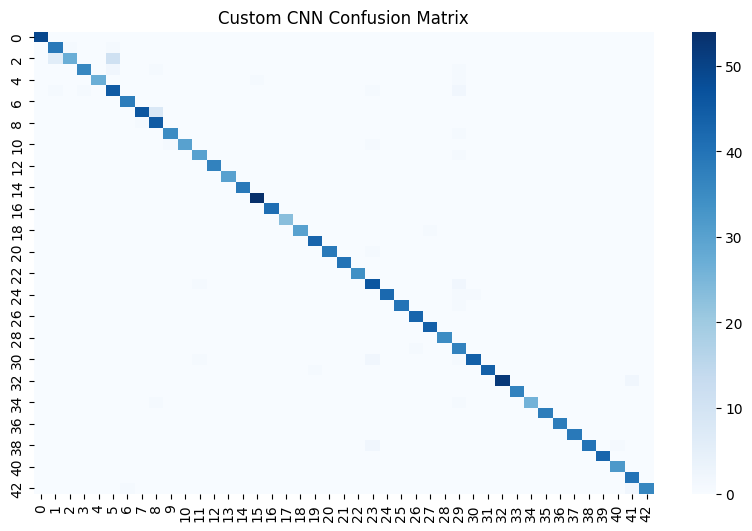


===== MobileNetV2 Evaluation =====
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        49
           1       0.42      0.41      0.42        41
           2       0.27      0.18      0.22        44
           3       0.46      0.33      0.38        40
           4       0.21      0.14      0.17        29
           5       0.34      0.60      0.43        50
           6       0.68      0.84      0.75        38
           7       0.74      0.52      0.61        54
           8       0.17      0.13      0.15        46
           9       0.68      0.58      0.63        36
          10       0.55      0.56      0.55        32
          11       0.58      0.23      0.33        31
          12       0.92      0.59      0.72        37
          13       0.70      1.00      0.82        30
          14       0.95      0.97      0.96        39
          15       1.00      0.91      0.95        54
   

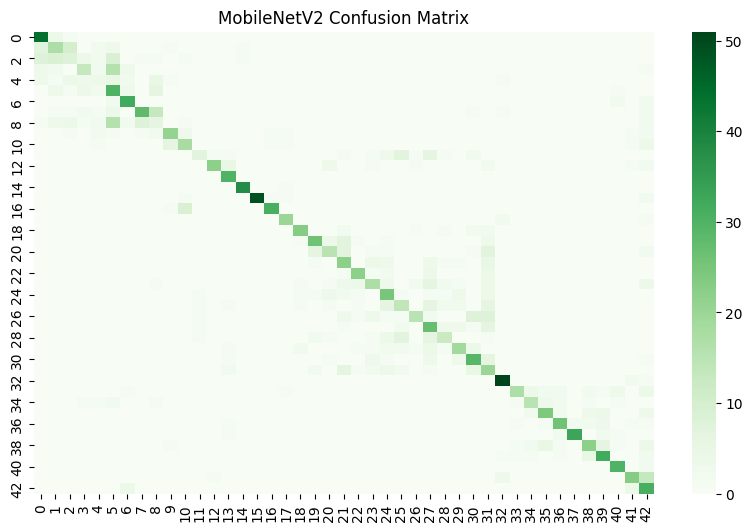

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# =======================
# Step 2: Load Dataset (FAST MODE)
# =======================
DATADIR = "/content/data/Train"
IMG_SIZE = 64

data, labels = [], []
classes = len(os.listdir(DATADIR))

for i in range(classes):
    path = os.path.join(DATADIR, str(i))
    for img in os.listdir(path)[:200]:  # FAST: max 200 images per class
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append(img_array)
            labels.append(i)
        except:
            pass

X = np.array(data) / 255.0
y = to_categorical(np.array(labels), classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Shape:", X_train.shape)

# =======================
# Step 3: Custom CNN
# =======================
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

# =======================
# Step 4: MobileNetV2 (Transfer Learning)
# =======================
IMG_SIZE_TL = 96
data_tl, labels_tl = [], []

for i in range(classes):
    path = os.path.join(DATADIR, str(i))
    for img in os.listdir(path)[:200]:
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_array = cv2.resize(img_array, (IMG_SIZE_TL, IMG_SIZE_TL))
            data_tl.append(img_array)
            labels_tl.append(i)
        except:
            pass

X_tl = preprocess_input(np.array(data_tl))
y_tl = to_categorical(np.array(labels_tl), classes)

X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(X_tl, y_tl, test_size=0.2, random_state=42)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE_TL, IMG_SIZE_TL, 3)))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(classes, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.fit(X_train_tl, y_train_tl, epochs=3, batch_size=32, validation_data=(X_test_tl, y_test_tl))

# =======================
# Step 5: Evaluation
# =======================
print("\n===== Custom CNN Evaluation =====")
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_true_cnn = np.argmax(y_test, axis=1)
print(classification_report(y_true_cnn, y_pred_cnn))

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(10,6))
sns.heatmap(cm_cnn, cmap="Blues")
plt.title("Custom CNN Confusion Matrix")
plt.show()

print("\n===== MobileNetV2 Evaluation =====")
y_pred_tl = np.argmax(mobilenet_model.predict(X_test_tl), axis=1)
y_true_tl = np.argmax(y_test_tl, axis=1)
print(classification_report(y_true_tl, y_pred_tl))

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
plt.figure(figsize=(10,6))
sns.heatmap(cm_tl, cmap="Greens")
plt.title("MobileNetV2 Confusion Matrix")
plt.show()
